# Numerical statibility for Direct deconvolution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
from scipy.linalg import cho_factor, cho_solve
import pickle

# 3D visualization
import pyvista as pv
pv.set_jupyter_backend('panel')

from gravmag import plot_functions as plf
from gravmag import eqlayer as eql
from gravmag import convolve as conv
from gravmag import constants as cts

### Data points

In [2]:
with open('data_points.pickle', 'rb') as f:
    data_points = pickle.load(f)

In [3]:
# number of points along x and y
print(data_points['shape'])

# minimum x, maximum x, minimum y and maximum y
print(data_points['area'])

(50, 50)
[-5000, 5000, -4000, 6000]


In [4]:
# Grid spacing
dx = (data_points['area'][1] - data_points['area'][0])/(data_points['shape'][0]-1)
dy = (data_points['area'][3] - data_points['area'][2])/(data_points['shape'][1]-1)

In [5]:
dx, dy

(204.08163265306123, 204.08163265306123)

In [6]:
# total number of data
D = np.prod(data_points['shape'])

In [7]:
D

2500

### Noise-free gravity data

In [8]:
with open('gravity_data.pickle', 'rb') as f:
    gravity_data = pickle.load(f)

### Noise-corrupted gravity data

In [9]:
with open('gravity_data_noisy.pickle', 'rb') as f:
    gravity_data_noisy = pickle.load(f)

### Set the equivalent sources location

In [10]:
# depth of the equivalent layer
Delta_z = 3*dx
z_layer = data_points['coordinates'][2,0] + Delta_z

In [11]:
z_layer

512.2448979591837

### Compute the first column of sensitivity matrix

In [12]:
# kernel matrix associated with the equivalent layer
G = cts.GRAVITATIONAL_CONST*cts.SI2MGAL*(
    eql.kernel_matrix_monopoles(data_points['coordinates'], z_layer, field="z")
)

In [13]:
G.shape

(2500, 2500)

In [14]:
# first column of the embedding BCCB matric
c0 = conv.embedding_BCCB_first_column(
    b0=G[:,0], Q=data_points['shape'][0], P=data_points['shape'][1], symmetry='symm-symm'
)

In [15]:
# matrix of eigenvalues
L = conv.eigenvalues_BCCB(
    c0=c0, Q=data_points['shape'][0], P=data_points['shape'][1]
)

### Define parameter $\zeta$

In [34]:
zetas = [1e-50, 1e-28, 1e-22, 1e-18]

### Define stability curves names

In [35]:
# define labels for noise levels
levels = [i for i in range(1,21)]

In [36]:
levels

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [37]:
data_norm = np.sqrt(np.sum(gravity_data['gz']*gravity_data['gz']))

In [38]:
names = ['unstable', 'suboptimal', 'optimal', 'overshoot']

In [39]:
### Compute the numerical stability curves
for (zeta, name) in zip(zetas, names):
    ### Estimate the physical-property distribution with noise-free data
    parameters = eql.method_direct_deconvolution(
        data=gravity_data['gz'], zeta=zeta, 
        L=L, Q=data_points['shape'][0], P=data_points['shape'][1], ordering="row", check_input=True
    )
    ### Estimate the physical-property distribution with noise-corrupted data to produce 
    ### the numerical stability curve
    model_perturbations = []
    data_perturbations = []

    parameters_norm = np.sqrt(np.sum(parameters*parameters))

    for level in levels:
        data_diff = gravity_data_noisy['d{}'.format(level)] - gravity_data['gz']
        data_perturbation = np.sqrt(np.sum(data_diff*data_diff))/data_norm
        data_perturbations.append(data_perturbation)

        # physical-property distribution with noise-corrupted data
        parameters_noisy = eql.method_direct_deconvolution(
            data=gravity_data_noisy['d{}'.format(level)], zeta=zeta, 
            L=L, Q=data_points['shape'][0], P=data_points['shape'][1], ordering="row", check_input=True
        )

        parameters_diff = parameters_noisy - parameters
        model_perturbation = np.sqrt(np.sum(parameters_diff*parameters_diff))/parameters_norm
        model_perturbations.append(model_perturbation)
    
    ### Store the data- and model-perturbations
    numerical_stability_curve = dict()
    numerical_stability_curve['model'] = model_perturbations
    numerical_stability_curve['data'] = data_perturbations
    
    ### Save the numerical stability curve
    file_name = 'deconv_'+name+'_stability.pickle'
    with open(file_name, 'wb') as f:
        pickle.dump(numerical_stability_curve, f)

### Plot the stability curves

In [40]:
colors = ['lightgrey', 'darkgrey', 'magenta', 'dimgrey']

In [41]:
linestyles = [':', ':', '-', ':']

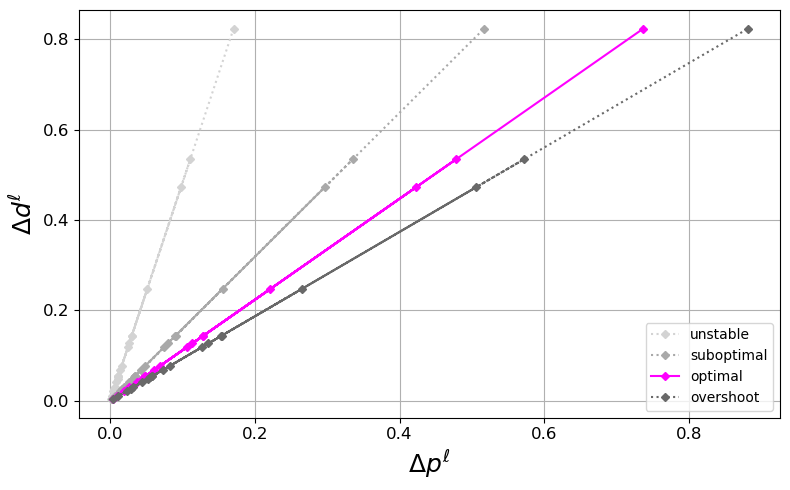

In [42]:
fig, ax = plt.subplots(figsize=(8,5))

for (color, linestyle, name) in zip(colors, linestyles, names):
    ### Open the stability curve
    file_name = 'deconv_'+name+'_stability.pickle'
    with open(file_name, 'rb') as f:
        numerical_stability_curve = pickle.load(f)

    ax.plot(
        numerical_stability_curve['model'], 
        numerical_stability_curve['data'], 
        linestyle=linestyle, color=color, marker='D', alpha=1, markersize=4, label=name)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('$\Delta p^{\ell}$', fontsize=18)
ax.set_ylabel('$\Delta d^{\ell}$', fontsize=18)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
#plt.savefig('../manuscript/Fig/deconv-stability.png', dpi= 300)
plt.show()